In [ ]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    recall_score,
    precision_score,
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,ConfusionMatrixDisplay
)
import os
from sklearn.model_selection import TimeSeriesSplit
import pickle

import datetime as dt
import time

## Data Visualizations

This file contains code to generate all of the visualizations that can be found in our presentation slides and/or readme file. 

Network multidigraph visualization examples 
Fraud transactions 


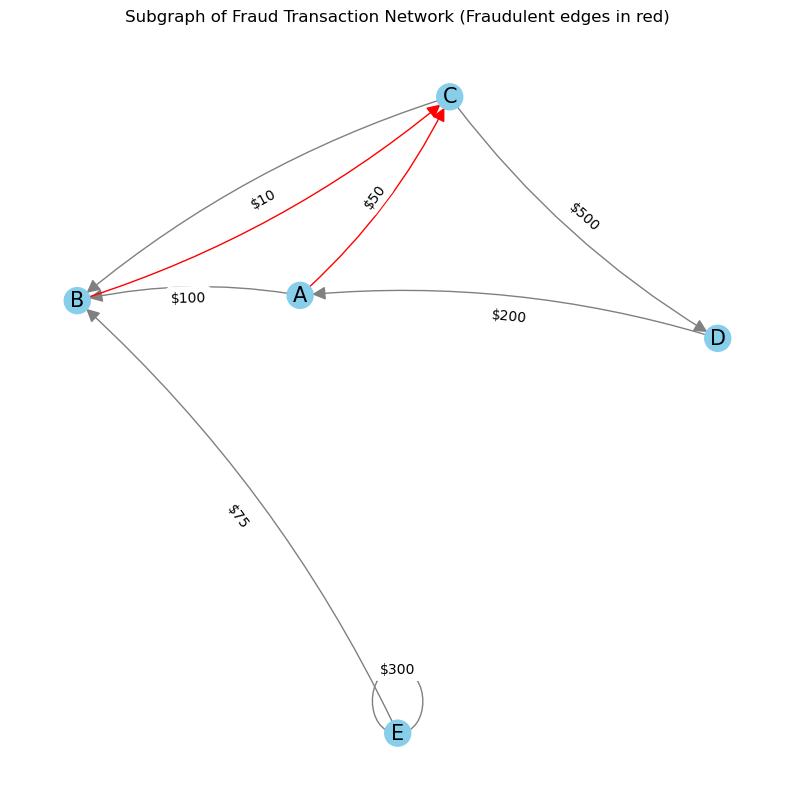

In [ ]:
# This plot is meant to quickly convey the meaning of a "transaction network multidigraph". We can descibe this as an a simplified example of a subgraph of our entire transaction network graph.
# instantiate multidigraph object
g = nx.MultiDiGraph()

# create accounts
accounts = ['A', 'B', 'C', 'D', 'E']

# add nodes from accounts
g.add_nodes_from(accounts)

# create transaction and add them as edges
g.add_edges_from([
        ('A', 'B', {'amount': '$100', 'Label': 'not fraud'}),
        ('A', 'C', {'amount': '$50', 'Label': 'fraud'}), # Fraudulent transaction
        ('B', 'C', {'amount': '$999', 'Label': 'fraud'}), # Fraudulent transaction
        ('C', 'D', {'amount': '$500', 'Label': 'not fraud'}),
        ('D', 'A', {'amount': '$200', 'Label': 'not fraud'}),
        ('E', 'B', {'amount': '$75', 'Label': 'not fraud'}),
        ('E', 'E', {'amount': '$300', 'Label': 'not fraud'}),
        ('C', 'B', {'amount': '$10', 'Label': 'not fraud' })
    ])

# 5. Prepare data for plotting
pos = nx.spring_layout(g, seed=831) # Set position for consistent layout
    
# Color nodes
node_colors = ['skyblue' for node in g.nodes()]

# Color edges: red for 'fraud', grey for 'legit'
edge_colors = []
for u, v, data in g.edges(data=True):
    if data.get('Label') == 'fraud':
        edge_colors.append('red')
    else:
        edge_colors.append('grey')

#Edge labels for transaction IDs
edge_labels = {(u, v): data['amount'] for u, v, data in g.edges(data=True)}

# 6. Plot the subgraph
plt.figure(figsize=(10, 10))
    
# Draw nodes
nx.draw_networkx_nodes(g, pos, node_color=node_colors, node_size=350)
    
# Draw edges with specific colors and curvature for multi-edges
nx.draw_networkx_edges(
        g, pos, 
        edge_color=edge_colors, 
        arrows=True, 
        arrowsize=20,
        connectionstyle='arc3,rad=0.1' # Adds curvature to distinguish parallel edges
    )

# Draw labels
nx.draw_networkx_labels(g, pos, font_size=15, font_color='black')
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='black' if 'red' in edge_colors else 'black')
    
plt.title("Subgraph of Fraud Transaction Network (Fraudulent edges in red)")
plt.axis('off')
plt.show()





Fraud Rings 

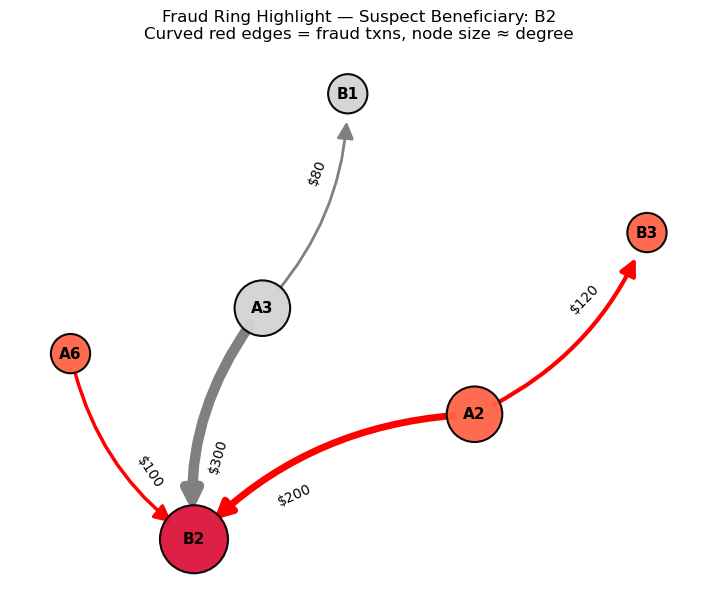

Suspected ring beneficiaries (>=2 unique fraud senders): ['B2']
  - B2: fraud senders ['A2', 'A6']


In [ ]:
#Here is the code for the synthetic fraud ring figure:                                                                                                           #Synthetic stream (sender, bene, sender_country, bene_country, amount, label)
df = pd.DataFrame([
    ("A1","B1","US","US",150,0),
    # fraud B2
    ("A2","B2","UK","US",200,1),
    ("A3","B1","US","FR",80,0),
     # fraud B3 (same sender A2)
    ("A2","B3","UK","UK",120,1),
    ("A4","B4","US","US",500,0),
    ("A3","B2","US","US",300,0),
    ("A5","B3","CA","UK",50,0),
    # fraud B2 (another sender ring around B2)
    ("A6","B2","CA","US",100,1),
], columns=["Sender","Bene","Sender_Country","Bene_Country","USD_amount","Label"])
#MultiDiGraph + attach attributes following
G = nx.MultiDiGraph()
for _, r in df.iterrows():
    s, b = r["Sender"], r["Bene"]
    if not G.has_node(s): G.add_node(s, role="sender", country=r["Sender_Country"], fraud_touch=0)
    if not G.has_node(b): G.add_node(b, role="bene",   country=r["Bene_Country"], fraud_touch=0)
    # increment fraud exposure if this transaction is fraudulent
    G.nodes[s]["fraud_touch"] += r["Label"]
    G.nodes[b]["fraud_touch"] += r["Label"]
    G.add_edge(s, b, Label=r["Label"], amount=r["USD_amount"])
#Here is the  part where I build ring candidate beneficiaries:
#bene nodes with >=2 unique senders where Label==1 toward them
fraud_edges = [(u,v,d) for u,v,d in G.edges(data=True) if d.get("Label",0)==1]
bene_to_senders = {}
for u,v,d in fraud_edges:
    bene_to_senders.setdefault(v, set()).add(u)
ring_candidates = [bene for bene, senders in bene_to_senders.items() if len(senders) >= 2]
#If not found, then fall back to highest in degree bene
if not ring_candidates:
    bene_degrees = [(n, G.in_degree(n)) for n,attr in G.nodes(data=True) if attr.get("role")=="bene"]
    ring_candidates = [max(bene_degrees, key=lambda x:x[1])[0]] if bene_degrees else []
#take top candidate (here it's B2)
suspect_bene = ring_candidates[0]
#egosubgraph around the suspect beneficiary
#undirected for neighborhood extraction
H = nx.ego_graph(G.to_undirected(), suspect_bene, radius=2)
H_multi = G.subgraph(H.nodes()).copy()
plt.figure(figsize=(9,7))
pos = nx.spring_layout(H_multi, seed=42, k=1.2)
#Node styling
node_sizes = []
node_colors = []
node_labels = {}
for n,attr in H_multi.nodes(data=True):
    deg = H_multi.in_degree(n) + H_multi.out_degree(n)
    node_sizes.append(max(300, deg*800))
    if n == suspect_bene:
        node_colors.append("crimson")
    elif attr.get("fraud_touch",0) > 0:
        node_colors.append("tomato")
    else:
        node_colors.append("lightgray")
    node_labels[n] = n
nx.draw_networkx_nodes(H_multi, pos, node_size=node_sizes, node_color=node_colors,
                       edgecolors="black", linewidths=1.5, alpha=0.95)
#Edges with curvature for parallel arrows
nx.draw_networkx_edges(
    H_multi, pos,
    edge_color=["red" if d.get("Label",0)==1 else "gray" for u,v,d in H_multi.edges(data=True)],
    width=[max(1.0, d.get("amount",0)/40.0) for u,v,d in H_multi.edges(data=True)],
    arrows=True,
    arrowsize=25,
    connectionstyle='arc3,rad=0.2',   # <— slightly more curved
    min_source_margin=15,
    min_target_margin=20
)
#Labels for nodes
nx.draw_networkx_labels(H_multi, pos, labels=node_labels, font_size=11, font_weight="bold")
#Edge amount labels
edge_labels = {(u,v): f"${d.get('amount',0)}" for u,v,k,d in H_multi.edges(keys=True, data=True)}
nx.draw_networkx_edge_labels(
    H_multi, pos,
    edge_labels=edge_labels,
    font_size=10,
    font_color="black",
    label_pos=0.65
)
plt.title(f"Fraud Ring Highlight — Suspect Beneficiary: {suspect_bene}\n"
          "Curved red edges = fraud txns, node size ≈ degree")
plt.axis("off")
plt.show()
#Print summary
print("Suspected ring beneficiaries (>=2 unique fraud senders):", ring_candidates)
for bene in ring_candidates:
    print(f"  - {bene}: fraud senders {sorted(list(bene_to_senders[bene]))}")

Count of Fraud Transactions by Transaction Type 

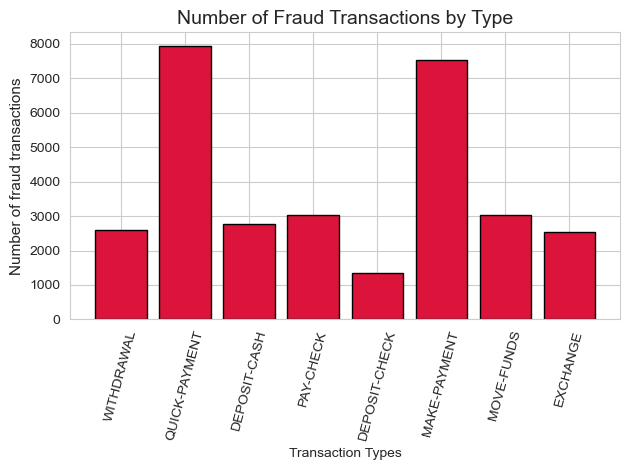

In [ ]:
sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)
# Loads full dataset
JPfraud_full  = pd.read_csv('/fraud_payment_data', sep=',', header=0)
JPfraud_full
# Removing $0 transactions, which contain no fraud labels
JPfraud = JPfraud_full[JPfraud_full.USD_amount > 0].reset_index(level=0,drop=True)

# Gathering the number of fraud and non-fraud transactions for each transaction type
trans_types = JPfraud.Transaction_Type.unique()
fraud_number = np.zeros(len(trans_types))
non_fraud_number = np.zeros(len(trans_types))

for i, trans in enumerate(trans_types):
    fraud_number[i] = JPfraud.loc[JPfraud.Transaction_Type == trans].Label.sum()
    non_fraud_number[i] = len(JPfraud[JPfraud.Label == 0].loc[JPfraud.Transaction_Type == trans])
plt.figure()

plt.bar(trans_types, fraud_number, edgecolor='black', color='crimson')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of fraud transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)),trans_types,rotation=75)
plt.title('Number of Fraud Transactions by Type',fontsize=14)
plt.tight_layout()
plt.savefig('Fraud_number_vs_transaction_types.png')
plt.show()




Count of Transaction Types Fraud vs. Non Fraud

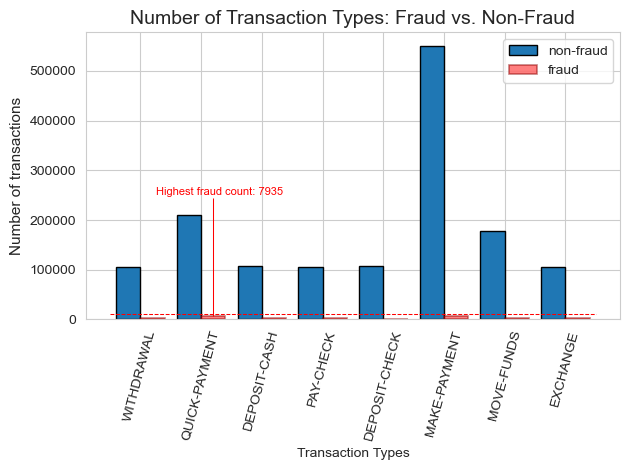

In [2]:
plt.figure()

w = 0.4

plt.bar(np.arange(len(trans_types))-w/2, non_fraud_number, label='non-fraud', edgecolor='black', width=w)
plt.bar(np.arange(len(trans_types))+w/2, fraud_number, alpha = 0.5, color='red', width=w,
        label='fraud', edgecolor='darkred', linewidth=1.2)
plt.hlines(y=fraud_number[1]+2038, xmin=-0.5, xmax=len(trans_types)-0.5,
           linewidth=0.75, color='red', linestyle='--')
plt.vlines(x=1.2, ymin=fraud_number[1], ymax=245000,
           linewidth=0.75, color='red', linestyle='-')
plt.text(0.25,250000, 'Highest fraud count: 7935', fontsize=8, color='red')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)), trans_types, rotation=75)
plt.title('Number of Transaction Types: Fraud vs. Non-Fraud',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('fraud_and_non-fraud_vs_transaction_types.png')
plt.show()

Recall-Lift Trade-off: XGBoost vs Logistic Regression

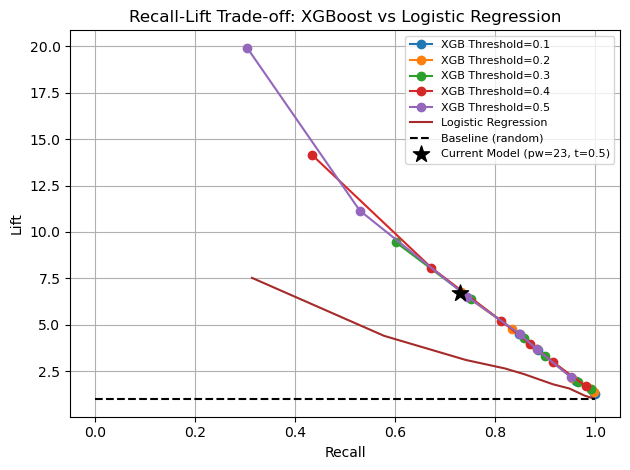

0

In [ ]:

final_features = pd.read_csv('/total_features_1', sep=',', header=0)
total_data = pd.read_csv('/fraud_payment_data', sep=',', header=0)

total_data=total_data[total_data.USD_amount>0]
total_data=total_data.reset_index(drop=True)
total_data


#Adding USD to final features because they were not included in the modeling features 
final_features["USD_amount"] = total_data["USD_amount"]

#Train, test, split 
train_features = final_features[0:1000000]
val_features = final_features[1000000:1250000]
test_features = final_features[1250000:-1]

y_train = total_data['Label'][0:1000000]
y_val   = total_data['Label'][1000000:1250000]
y_test  = total_data['Label'][1250000:-1]

#Fit scaler on TRAIN ONLY - this learns mean and std from training set 
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features)

# Transform val/test using the SAME scaler
X_val  = scaler.transform(val_features)
X_test = scaler.transform(test_features)



# Create DataFrame from test_features to extract column names
df_temp = pd.DataFrame(test_features)
feature_names = train_features.columns.tolist()  

# combine training + validation
X_final = np.vstack([X_train, X_val])
y_final = np.concatenate([y_train, y_val])

# final optimized XGB
final_model = XGBClassifier(
    colsample_bytree=0.8, 
  gamma=0.1, 
  learning_rate=0.01, 
  max_depth=8,
  min_child_weight=2,
  n_estimators= 600, 
  subsample= 0.9,
  scale_pos_weight=23,
  random_state=831
)

final_model.fit(X_final, y_final)

import matplotlib.pyplot as plt

# Vizualizing XGBoost curves - recall vs. lift, XGBoost vs. LR 
base_params = {
    'colsample_bytree': 0.8, 
    'gamma': 0.1, 
    'learning_rate': 0.01, 
    'max_depth': 8,
    'min_child_weight': 2,
    'n_estimators': 600, 
    'subsample': 0.9,
    'random_state': 831
}

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
pos_weights = [5, 10, 23, 50, 100, 200]

for thresh in thresholds:
    recalls = []
    lifts = []
    
    for pw in pos_weights:
        xgb = XGBClassifier(**base_params, scale_pos_weight=pw)
        xgb.fit(X_final, y_final)
        
        y_prob = xgb.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= thresh).astype(int)
        
        recall = recall_score(y_test, y_pred)
        ppr = y_pred.sum() / len(y_pred)
        lift = recall / ppr if ppr > 0 else 0
        
        recalls.append(recall)
        lifts.append(lift)
    
    plt.plot(recalls, lifts, 
              marker='o',
              label=f'XGB Threshold={thresh}')

# Logistic Regression curve
lr_recalls = []
lr_lifts = []
class_weights = [10, 25, 49, 75, 100, 150, 200, 300, 500]

for cw in class_weights:
    lr = LogisticRegression(class_weight={0: 1, 1: cw}, max_iter=1000)
    lr.fit(X_final, y_final)
    
    y_prob_lr = lr.predict_proba(X_test)[:, 1]
    y_pred_lr = (y_prob_lr >= 0.5).astype(int)
    
    recall_lr = recall_score(y_test, y_pred_lr)
    ppr_lr = y_pred_lr.sum() / len(y_pred_lr)
    lift_lr = recall_lr / ppr_lr if ppr_lr > 0 else 0
    
    lr_recalls.append(recall_lr)
    lr_lifts.append(lift_lr)

plt.plot(lr_recalls, lr_lifts, label='Logistic Regression', color='brown')

plt.plot([0, 1], [1, 1], 'k--', label='Baseline (random)')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Recall-Lift Trade-off: XGBoost vs Logistic Regression')
plt.legend()
plt.grid(True)
#annotation for your optimal model
plt.scatter([0.73], [6.7], s=150, color='black', marker='*', zorder=5, label='Current Model (pw=23, t=0.5)')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

os.system('say "Your graph is ready."')






Business KPIs and Optimal Threshold

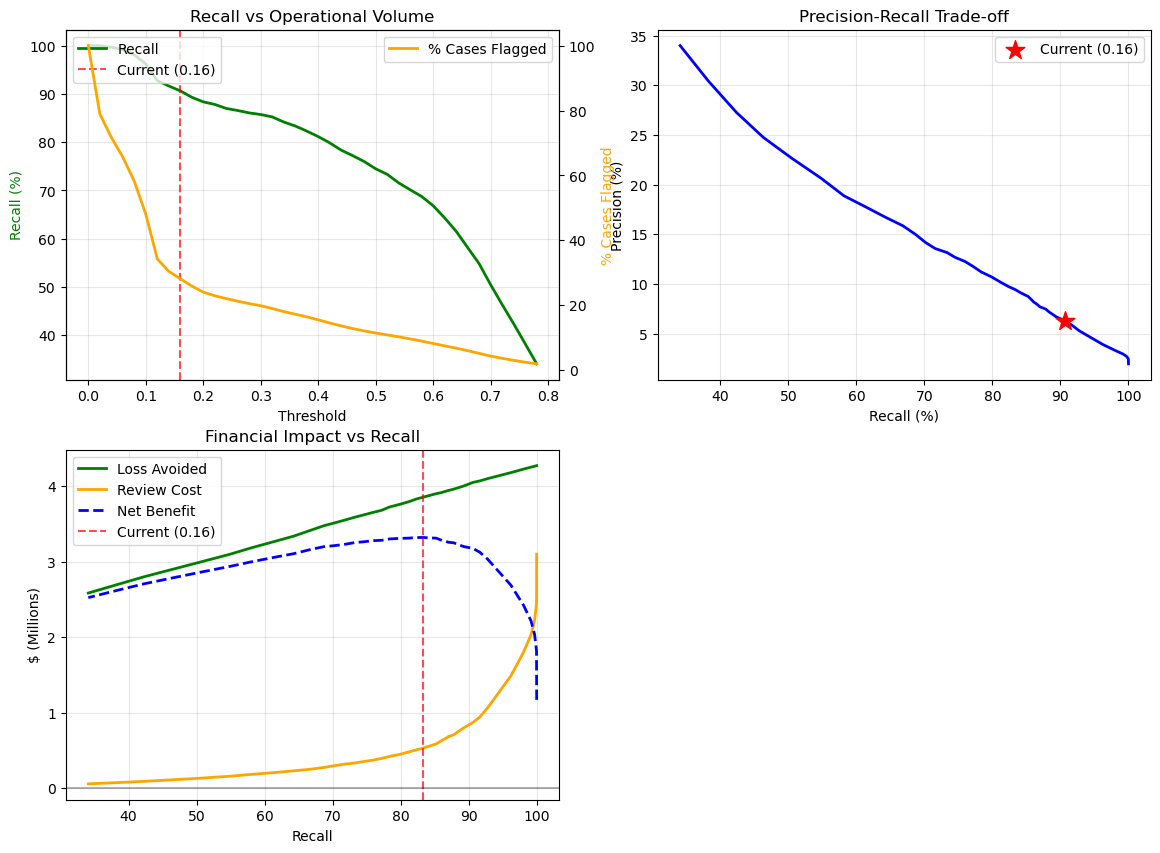

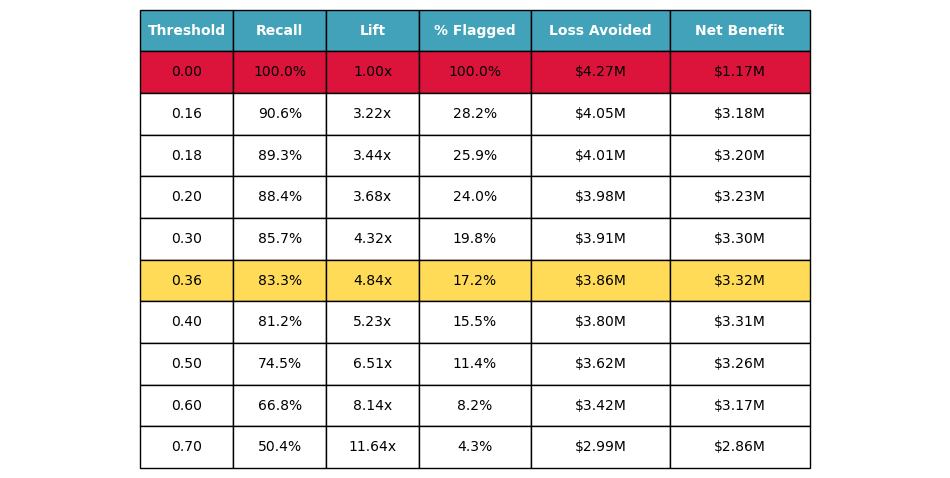


Optimal Results:
  Recall: 83.3%
  Lift: 4.84x
  % Flagged: 17.2%
  Loss Avoided: $3.86M
  Review Cost: $0.53M
  Net Benefit: $3.32M


In [ ]:
#Calculate metrics across threshold range
thresholds = np.arange(0, 0.80, 0.02)

results = []
for thresh in thresholds:
    flagged = (df_test["model_score"] >= thresh).sum()
    flagged_pct = flagged / len(df_test)
    
    caught = ((df_test["is_fraud"] == 1) & (df_test["model_score"] >= thresh)).sum()
    recall = caught / df_test["is_fraud"].sum()
    
    precision = caught / flagged if flagged > 0 else 0
    
    #Financial metrics
    df_test["temp_flag"] = (df_test["model_score"] >= thresh).astype(int)
    loss_avoided_thresh = (df_test["synthetic_loss"] * df_test["temp_flag"]).sum()
    review_cost_thresh = flagged * 12.50  # $12.50 per case
    net_benefit = loss_avoided_thresh - review_cost_thresh
    
    results.append({
        'threshold': thresh,
        'flagged_pct': flagged_pct * 100,
        'recall': recall * 100,
        'precision': precision * 100,
        'loss_avoided': loss_avoided_thresh / 1e6,  #millions
        'review_cost': review_cost_thresh / 1e6,  #millions
        'net_benefit': net_benefit / 1e6  #millions
    })

#Create DataFrame for easy plotting
df_threshold = pd.DataFrame(results)

#Create visualizations
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
# fig = plt.figure(figsize=(14, 10))
# gs = fig.add_gridspec(2, 2)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]

# Leave bottom-right empty
axs[1, 1].axis('off')


#Plot 1: Recall vs % Flagged
ax1.plot(df_threshold['threshold'], df_threshold['recall'], 'g-', linewidth=2, label='Recall')
ax1_twin = ax1.twinx()
ax1_twin.plot(df_threshold['threshold'], df_threshold['flagged_pct'], 'orange', linewidth=2, label='% Cases Flagged')
ax1.axvline(x=0.16, color='red', linestyle='--', alpha=0.7, label='Current (0.16)')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Recall (%)', color='g')
ax1_twin.set_ylabel('% Cases Flagged', color='orange')
ax1.set_title('Recall vs Operational Volume')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

#Plot 2: Precision vs Recall
ax2.plot(df_threshold['recall'], df_threshold['precision'], 'b-', linewidth=2)
current_idx = df_threshold[df_threshold['threshold'].round(2) == 0.16].index[0]
ax2.scatter(df_threshold.loc[current_idx, 'recall'], 
            df_threshold.loc[current_idx, 'precision'], 
            color='red', s=200, marker='*', zorder=5, label='Current (0.16)')
ax2.set_xlabel('Recall (%)')
ax2.set_ylabel('Precision (%)')
ax2.set_title('Precision-Recall Trade-off')
ax2.grid(True, alpha=0.3)
ax2.legend()

#Plot 3: Financial Impact
ax3.plot(df_threshold['recall'], df_threshold['loss_avoided'], 'g-', linewidth=2, label='Loss Avoided')
ax3.plot(df_threshold['recall'], df_threshold['review_cost'], 'orange', linewidth=2, label='Review Cost')
ax3.plot(df_threshold['recall'], df_threshold['net_benefit'], 'b--', linewidth=2, label='Net Benefit')
ax3.axvline(x=83.3, color='red', linestyle='--', alpha=0.7, label='Current (0.16)')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.set_xlabel('Recall')
ax3.set_ylabel('$ (Millions)')
ax3.set_title('Financial Impact vs Recall')
ax3.grid(True, alpha=0.3)
ax3.legend()

#Calculate lift in the results loop, adding to loop
results = []
for thresh in thresholds:
    flagged = (df_test["model_score"] >= thresh).sum()
    flagged_pct = flagged / len(df_test)
    
    caught = ((df_test["is_fraud"] == 1) & (df_test["model_score"] >= thresh)).sum()
    recall = caught / df_test["is_fraud"].sum()
    
    precision = caught / flagged if flagged > 0 else 0
    
    # Calculate lift (recall / PPR)
    lift = recall / flagged_pct if flagged_pct > 0 else 0
    
    # Financial metrics
    df_test["temp_flag"] = (df_test["model_score"] >= thresh).astype(int)
    loss_avoided_thresh = (df_test["synthetic_loss"] * df_test["temp_flag"]).sum()
    review_cost_thresh = flagged * 12.50
    net_benefit = loss_avoided_thresh - review_cost_thresh
    
    results.append({
        'threshold': thresh,
        'flagged_pct': flagged_pct * 100,
        'recall': recall * 100,
        'precision': precision * 100,
        'lift': lift, 
        'loss_avoided': loss_avoided_thresh / 1e6,
        'review_cost': review_cost_thresh / 1e6,
        'net_benefit': net_benefit / 1e6
    })

df_threshold = pd.DataFrame(results)

#Plot 4: Summary Table 
key_thresholds = [0, 0.15, 0.16, 0.18, 0.20, 0.25, 0.30,0.36,0.4,0.45,0.5,0.6,0.7,]
table_data = []
for thresh in key_thresholds:
    row = df_threshold[df_threshold['threshold'].round(2) == thresh]
    if not row.empty:
        table_data.append([
            f"{thresh:.2f}",
            f"{row['recall'].values[0]:.1f}%",
            f"{row['lift'].values[0]:.2f}x",
            f"{row['flagged_pct'].values[0]:.1f}%",
            f"${row['loss_avoided'].values[0]:.2f}M",
            f"${row['net_benefit'].values[0]:.2f}M"
        ])
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=table_data,
    colLabels=['Threshold', 'Recall', 'Lift', '% Flagged', 'Loss Avoided', 'Net Benefit'],
    cellLoc='center',
    loc='center',
    colWidths=[0.10, 0.10, 0.10, 0.12, 0.15, 0.15]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)


# Style header
for i in range(6):
   table[(0, i)].set_facecolor('#42A2B9')
   table[(0, i)].set_text_props(weight='bold', color='white')
# Highlight current threshold row (0.16)
for i in range(len(table_data)):
    if table_data[i][0] == '0.36':
        for j in range(len(table_data[i])):
             table[(i+1, j)].set_facecolor("#FFDB58")
    if table_data[i][0] == '0.00':
        for j in range(len(table_data[i])):
             table[(i+1, j)].set_facecolor("#DC143C")
plt.savefig('threshold_table_only.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

#Optimal threshold
optimal_idx = df_threshold['net_benefit'].idxmax()
optimal = df_threshold.loc[optimal_idx]
print(f"\nOptimal Results:")
print(f"  Recall: {optimal['recall']:.1f}%")
print(f"  Lift: {optimal['lift']:.2f}x") 
print(f"  % Flagged: {optimal['flagged_pct']:.1f}%")
print(f"  Loss Avoided: ${optimal['loss_avoided']:.2f}M")
print(f"  Review Cost: ${optimal['review_cost']:.2f}M")
print(f"  Net Benefit: ${optimal['net_benefit']:.2f}M")